In [22]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

# torchvision 包包含了三个模块
# datasets 这个模块包含了很多数据集
# models 这个模块包含了常用的网络结构
# transforms 这个模块包含了图片转换需要用到的方法

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 要想使CUDA加速明显，每一批的数量就应该加大

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=40,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  dog  deer truck plane   dog horse   dog   cat truck   cat   car  bird truck truck   car  ship plane   cat horse horse horse  bird plane truck   car  bird   dog  frog  frog truck   car  frog horse  ship   car truck   cat  deer   car   cat


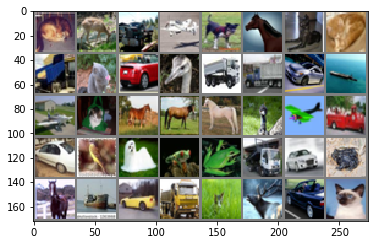

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(40)))

In [24]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 我想用cuda加速
net.to(device)
print(net)

cuda:0
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [46]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    # i+1 表示有多少个mini-batch
    print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
    running_loss = 0.0

print('Finished Training')

[1,  1250] loss: 953.798
[2,  1250] loss: 930.906
[3,  1250] loss: 910.160
[4,  1250] loss: 890.155
[5,  1250] loss: 874.023
[6,  1250] loss: 855.150
[7,  1250] loss: 835.430
[8,  1250] loss: 820.307
[9,  1250] loss: 798.847
[10,  1250] loss: 781.731
[11,  1250] loss: 766.655
[12,  1250] loss: 750.337
[13,  1250] loss: 735.655
[14,  1250] loss: 718.100
[15,  1250] loss: 701.422
[16,  1250] loss: 688.422
[17,  1250] loss: 669.807
[18,  1250] loss: 655.003
[19,  1250] loss: 640.873
[20,  1250] loss: 625.870
[21,  1250] loss: 608.484
[22,  1250] loss: 600.627
[23,  1250] loss: 581.175
[24,  1250] loss: 571.632
[25,  1250] loss: 554.124
[26,  1250] loss: 542.873
[27,  1250] loss: 526.599
[28,  1250] loss: 511.341
[29,  1250] loss: 508.002
[30,  1250] loss: 492.657
[31,  1250] loss: 475.518
[32,  1250] loss: 475.586
[33,  1250] loss: 459.293
[34,  1250] loss: 451.902
[35,  1250] loss: 436.123
[36,  1250] loss: 418.438
[37,  1250] loss: 427.481
[38,  1250] loss: 408.292
[39,  1250] loss: 399

In [53]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
# print images
# 用了CUDA图片就不秀了，要秀需要转存到CPU，或者再转存显存以前先秀
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(40)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(40)))

Predicted:    cat  ship  ship plane  frog  frog   dog  bird   cat   car plane truck   dog horse   car  ship   dog horse  ship  bird truck  bird plane truck   cat   dog  deer  bird truck  frog  frog   dog  deer   dog truck  ship horse   car truck   dog


In [54]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
# 增多训练EPOCH，正确率会上升，但也应该防止由此带来的过拟合问题
# 事实上，10次和00次得到的结果差不多，在形变比较大的动物上，正确率只有不到百分之五十

Accuracy of plane : 72 %
Accuracy of   car : 76 %
Accuracy of  bird : 48 %
Accuracy of   cat : 41 %
Accuracy of  deer : 42 %
Accuracy of   dog : 43 %
Accuracy of  frog : 79 %
Accuracy of horse : 70 %
Accuracy of  ship : 69 %
Accuracy of truck : 71 %


In [47]:
# 使用CUDA去计算，主要是需要将Tensor和网络Model也如GPU，用to.(device)方法即可
# 如果有多块GPU，就需要使用DataParallel方法了
# 下面这一部分主要是介绍如何使用多块GPU训练网络
# model = nn.DataParallel(model)、

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Parameters and DataLoaders
input_size = 5
output_size = 2

batch_size = 30
data_size = 100


In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
class RandomDataset(Dataset):

    def __init__(self, size, length):
        self.len = length
        self.data = torch.randn(length, size)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(input_size, 100),
                         batch_size=batch_size, shuffle=True)

In [50]:
class Model(nn.Module):
    # Our model

    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, input):
        output = self.fc(input)
        print("\tIn Model: input size", input.size(),
              "output size", output.size())

        return output

In [51]:
model = Model(input_size, output_size)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model.to(device)

Model(
  (fc): Linear(in_features=5, out_features=2, bias=True)
)

In [52]:
# 这段代码会随你的显卡数解锁不一样的信息，我穷，就只有一个

for data in rand_loader:
    input = data.to(device)
    output = model(input)
    print("Outside: input size", input.size(),
          "output_size", output.size())

	In Model: input size torch.Size([30, 5]) output size torch.Size([30, 2])
Outside: input size torch.Size([30, 5]) output_size torch.Size([30, 2])
	In Model: input size torch.Size([30, 5]) output size torch.Size([30, 2])
Outside: input size torch.Size([30, 5]) output_size torch.Size([30, 2])
	In Model: input size torch.Size([30, 5]) output size torch.Size([30, 2])
Outside: input size torch.Size([30, 5]) output_size torch.Size([30, 2])
	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
Outside: input size torch.Size([10, 5]) output_size torch.Size([10, 2])
